<a href="https://colab.research.google.com/github/AdityaKendre02/PokemonDatasetAnalysis/blob/main/SI_671_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **1. Import Libraries**




In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
plt.rcParams.update({"figure.figsize": (9, 6)})



# **2. Load Data & Preprocessing**

In [162]:
df = pd.read_csv("Pokemon.csv")
df.isna().sum()

,0
#,0
Name,0
Type 1,0
Type 2,386
Total,0
HP,0
Attack,0
Defense,0
Sp. Atk,0
Sp. Def,0


In [163]:
print("Original shape:", df.shape)

# Clean type columns
if 'Type 1' in df.columns:
    df['Type 1'] = df['Type 1'].astype(str).str.title()

if 'Type 2' in df.columns:
    df['Type 2'] = df['Type 2'].fillna('None').astype(str).str.title()

# Drop useless identifier columns
for col in ['#', 'Number', 'Id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Convert Legendary to integer
if 'Legendary' in df.columns:
    df['Legendary'] = df['Legendary'].astype(int)

# Fill numeric NaNs with median (Not needed but still written as a precautionary measure)
numeric_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for c in numeric_cols:
    if c in df.columns and df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)

# Add label
df['Label'] = df.index.astype(str)

print("Preprocessed shape:", df.shape)


Original shape: (800, 13)
Preprocessed shape: (800, 13)


In [164]:
df

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Label
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0,0
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0,1
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0,2
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0,3
4,Charmander,Fire,None,309,39,52,43,60,50,65,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,1,795
796,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,1,796
797,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,1,797
798,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,1,798


In [165]:
df['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [166]:
df['Type 2'].unique()

array(['Poison', 'None', 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

# **3. Feature Scaling (Normalization)**

In [167]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])


# **4. PCA (Dimensionality Reduction)**

In [168]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['PC1'], df['PC2'] = X_pca[:, 0], X_pca[:, 1]
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.45190665 0.18225358]


# **4A. PCA Biplot**

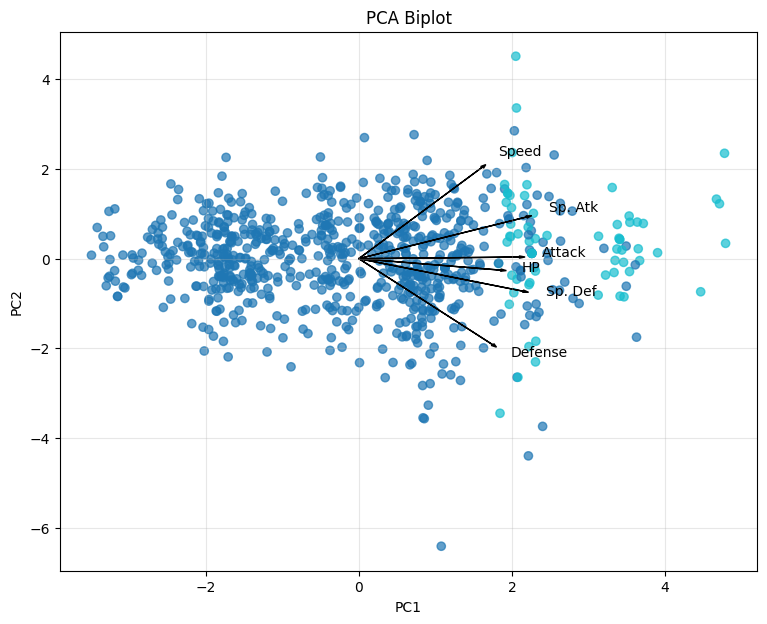

In [169]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=numeric_cols, columns=['PC1', 'PC2'])

def plot_pca_biplot(df, loadings_df, color_col=None, arrow_scale=3.0):
    plt.figure(figsize=(9, 7))

    # Scatter plot
    if color_col:
        plt.scatter(df['PC1'], df['PC2'], c=df[color_col], cmap='tab10', alpha=0.7)
    else:
        plt.scatter(df['PC1'], df['PC2'], color='blue', alpha=0.7)

    # Loadings (arrows)
    for feat in loadings_df.index:
        x, y = loadings_df.loc[feat]
        plt.arrow(0, 0, x * arrow_scale, y * arrow_scale,
                  color='black', head_width=0.05, length_includes_head=True)
        plt.text(x * arrow_scale * 1.1,
                 y * arrow_scale * 1.1,
                 feat, fontsize=10)

    # Labels
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Biplot')
    plt.grid(alpha=0.3)
    plt.show()

# Plot
plot_pca_biplot(df, loadings_df, color_col='Legendary')


PC1 captures most of the spread and it mainly reflects overall strength through high values for Attack HP and Sp. Atk. Pokemon that score high on these tend to move toward the right side of the biplot. PC2 separates Pokemon that rely more on Speed or defense related stats. Fast but lighter Pokemon move upward while sturdier ones shift downward. Legendary entries gather toward the right which matches their stronger balanced stats. Since PC1 and PC2 together explain most of the structure this view gives a clear sense of how the main stats group the Pokemon into broad styles of play.

# **5. K-Means Clustering**

Silhouette Score: 0.22579477253530672


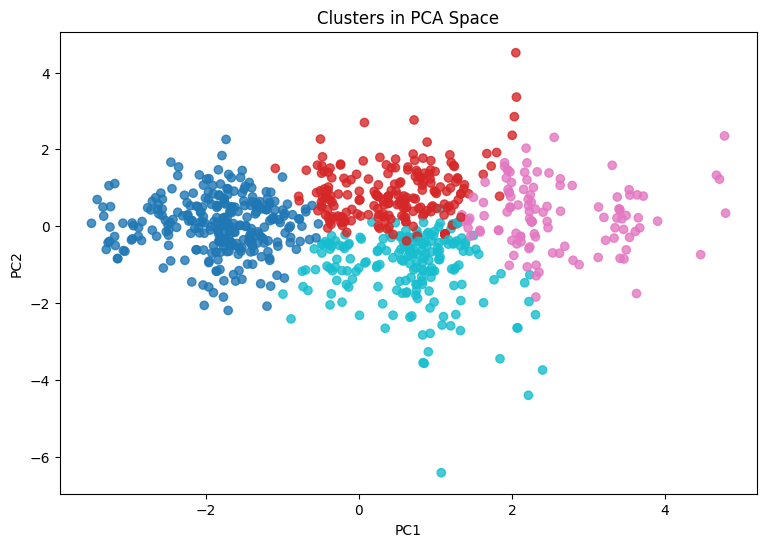

In [170]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)
print("Silhouette Score:", silhouette_score(X_scaled, df['Cluster']))


plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='tab10', alpha=0.8)
plt.title("Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [171]:
import numpy as np

# global means to compare high vs low
global_means = df[numeric_cols].mean()

cluster_labels = {}

for c in sorted(df['Cluster'].unique()):
    group = df[df['Cluster'] == c]

    labels = []

    # 1. Legendary indicator (always first)
    legendary_ratio = group['Legendary'].mean()
    if legendary_ratio > 0.4:
        labels.append("Legendary")
    else:
        labels.append("Non Legendary")

    # 2. Best global Type indicator
    cluster_type_shares = (
        group['Type 1'].value_counts() / df['Type 1'].value_counts()
    ).fillna(0)

    best_type = cluster_type_shares.index[cluster_type_shares.argmax()]
    best_value = cluster_type_shares.max()

    # type only if cluster truly owns it
    if best_value >= 0.51:
        labels.append(best_type)
    else:
        labels.append("Mixed Types")

    # 3. Stat indicators: pick all, sort by strength
    stat_diffs = {}

    for col in numeric_cols:
        mean_val = group[col].mean()
        diff = mean_val - global_means[col]

        # strong high indicator
        if mean_val > global_means[col] * 1.20:
            stat_diffs[f"High {col}"] = abs(diff)

        # strong low indicator
        elif mean_val < global_means[col] * 0.80:
            stat_diffs[f"Low {col}"] = abs(diff)

    # sort stat indicators by strongest difference first
    sorted_stats = sorted(stat_diffs, key=stat_diffs.get, reverse=True)

    # add all indicators in sorted order
    labels.extend(sorted_stats)

    cluster_labels[c] = labels

# print the final ordered labels
for c, lbls in cluster_labels.items():
    print(f"Cluster {c}: {lbls}")


Cluster 0: ['Non Legendary', 'Mixed Types', 'Low Attack', 'Low Sp. Atk', 'Low Sp. Def', 'Low Defense', 'Low HP', 'Low Speed']
Cluster 1: ['Non Legendary', 'Mixed Types', 'High Speed']
Cluster 2: ['Legendary', 'Dragon', 'High Sp. Atk', 'High Attack', 'High Sp. Def', 'High Speed', 'High HP', 'High Defense']
Cluster 3: ['Non Legendary', 'Steel', 'High Defense', 'Low Speed']


Cluster interpretations

Cluster 0
This group contains weaker Pokemon across every stat. They have low HP, low defense, low attack, and slow speed. They are almost entirely non legendary and have no clear type concentration.

Cluster 1
This group is defined mainly by very high speed. They are non legendary and do not lean toward any single type. These Pokemon are likely fast sweepers that rely on quick moves rather than bulk.

Cluster 2
This group gathers almost all high strength Pokemon. They score very high in every major stat including HP, attack, defense, special attack, special defense, and speed. Most of the legendary Pokemon fall here which explains the strong overall profile and dragon types are known to have better attributes.

Cluster 3
This group contains sturdy defensive Pokemon. They have high defense but low speed which suggests slow tanklike entries. They are non legendary and show a strong type pattern of Steel which is obvious because steel has high defense but low speed.

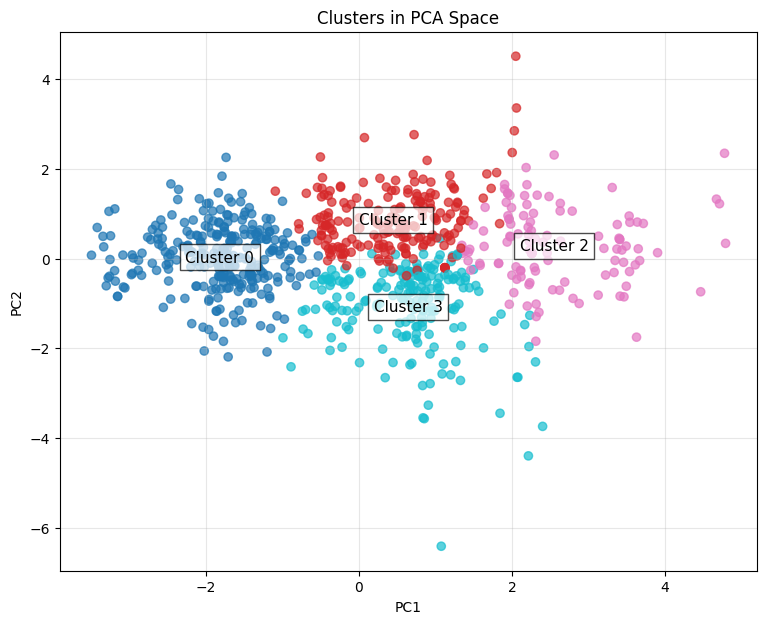

In [172]:
# Plot the PCA scatter colored by cluster
plt.figure(figsize=(9, 7))
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='tab10', alpha=0.7)

# Compute cluster centroids in PCA space
centers = df.groupby('Cluster')[['PC1', 'PC2']].mean()

# Add simple labels at cluster centers
for c in centers.index:
    x = centers.loc[c, 'PC1']
    y = centers.loc[c, 'PC2']
    plt.text(
        x, y,
        f"Cluster {c}",
        fontsize=11,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

# Title and axes
plt.title("Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


In [173]:
# sample 4 rows per cluster
sampled = df.groupby('Cluster').sample(n=2, random_state=671)


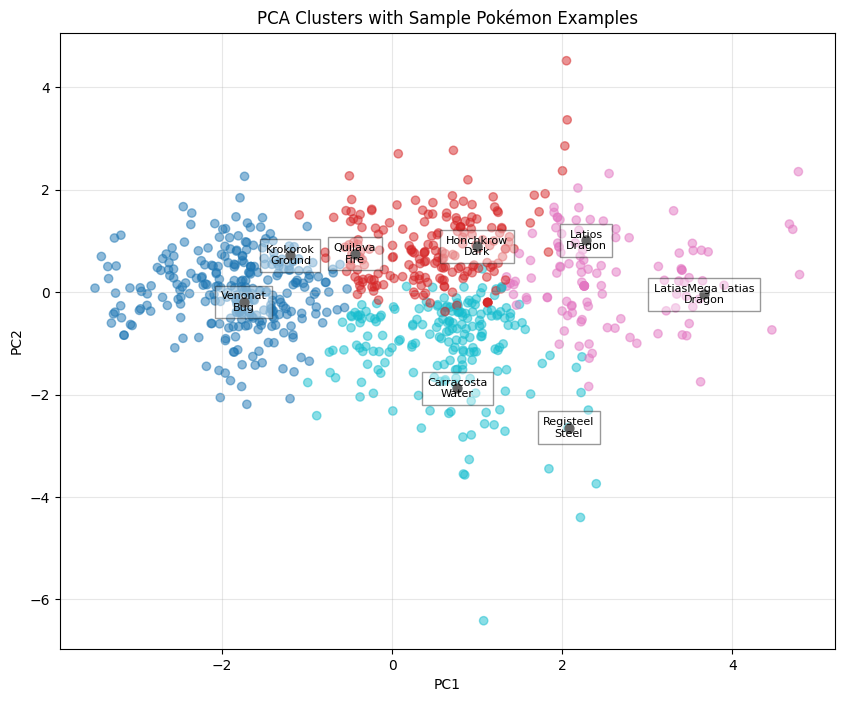

In [185]:
plt.figure(figsize=(10, 8))

# base scatter with clusters
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='tab10', alpha=0.5)

# mark sampled Pokémon
for _, row in sampled.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color='black', s=40)
    plt.text(
        row['PC1'],
        row['PC2'],
        f"{row['Name']}\n{row['Type 1']}",
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.4, edgecolor='black')
    )

# cluster centroids
centers = df.groupby('Cluster')[['PC1', 'PC2']].mean()

plt.title("PCA Clusters with Sample Pokémon Examples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


In [175]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_cols)
centers


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,-0.750260,-0.771524,-0.704404,-0.757142,-0.815867,-0.648199
1,0.001112,0.163568,-0.254512,0.327344,0.040886,0.907168
2,0.981460,1.079510,0.664957,1.370938,1.142852,0.935693
3,0.496156,0.305784,0.871438,-0.047551,0.456016,-0.537061


In [176]:
df.groupby('Cluster')['Type 1'].agg(lambda x: x.value_counts().index[0])


,Type 1
Cluster,
0,Normal
1,Normal
2,Dragon
3,Water


In [177]:
df.groupby('Cluster')['Legendary'].mean()


,Legendary
Cluster,
0,0.000000
1,0.014851
2,0.504348
3,0.020000


In [178]:
df.groupby('Cluster')[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']].mean()


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Cluster,,,,,,
0,50.113074,53.975265,51.890459,48.060071,49.212014,49.452297
1,69.287129,84.306931,65.910891,83.524752,73.039604,94.623762
2,94.304348,114.017391,94.565217,117.652174,103.686957,95.452174
3,81.920000,88.920000,101.000000,71.265000,84.585000,52.680000


# **5A. Cluster Summaries**

In [179]:
cluster_means = df.groupby('Cluster')[numeric_cols + ['Legendary']].mean().round(2)
cluster_means['Count'] = df['Cluster'].value_counts().sort_index()
print(cluster_means)

            HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Legendary  Count
Cluster                                                                   
0        50.11   53.98    51.89    48.06    49.21  49.45       0.00    283
1        69.29   84.31    65.91    83.52    73.04  94.62       0.01    202
2        94.30  114.02    94.57   117.65   103.69  95.45       0.50    115
3        81.92   88.92   101.00    71.26    84.58  52.68       0.02    200


# **6. Network Construction (Cosine Similarity Graph)**

In [180]:
sim_matrix = cosine_similarity(X_scaled)
threshold = 0.9
G = nx.Graph()

# Add nodes
for i in df.index:
    G.add_node(i)

# Add edges where similarity exceeds threshold
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if sim_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=float(sim_matrix[i, j]))

print("Graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


Graph: 800 nodes, 6927 edges


# **7. Centrality Measures**

In [181]:

degree_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G)
close_cent = nx.closeness_centrality(G)


df['DegreeCent'] = df.index.map(degree_cent)
df['BetweennessCent'] = df.index.map(bet_cent)
df['ClosenessCent'] = df.index.map(close_cent)
print(df[['DegreeCent', 'BetweennessCent', 'ClosenessCent']])



     DegreeCent  BetweennessCent  ClosenessCent
0      0.045056         0.000551       0.145660
1      0.003755         0.007123       0.108955
2      0.020025         0.009050       0.134879
3      0.018773         0.002262       0.129238
4      0.077597         0.001715       0.150768
..          ...              ...            ...
795    0.006258         0.000477       0.119221
796    0.006258         0.000055       0.132298
797    0.008761         0.000096       0.125938
798    0.007509         0.000005       0.122487
799    0.010013         0.000798       0.129288

[800 rows x 3 columns]


# **8. Community Detection (Modularity)**

In [182]:
communities = list(greedy_modularity_communities(G))
mod_score = nx.algorithms.community.modularity(G, communities)
print("Modularity Score:", mod_score)

community_map = {}
for cid, comm in enumerate(communities):
    for node in comm:
        community_map[node] = cid
df['Community'] = df.index.map(community_map)


Modularity Score: 0.43170019331192105


# **9. Network Visualization**

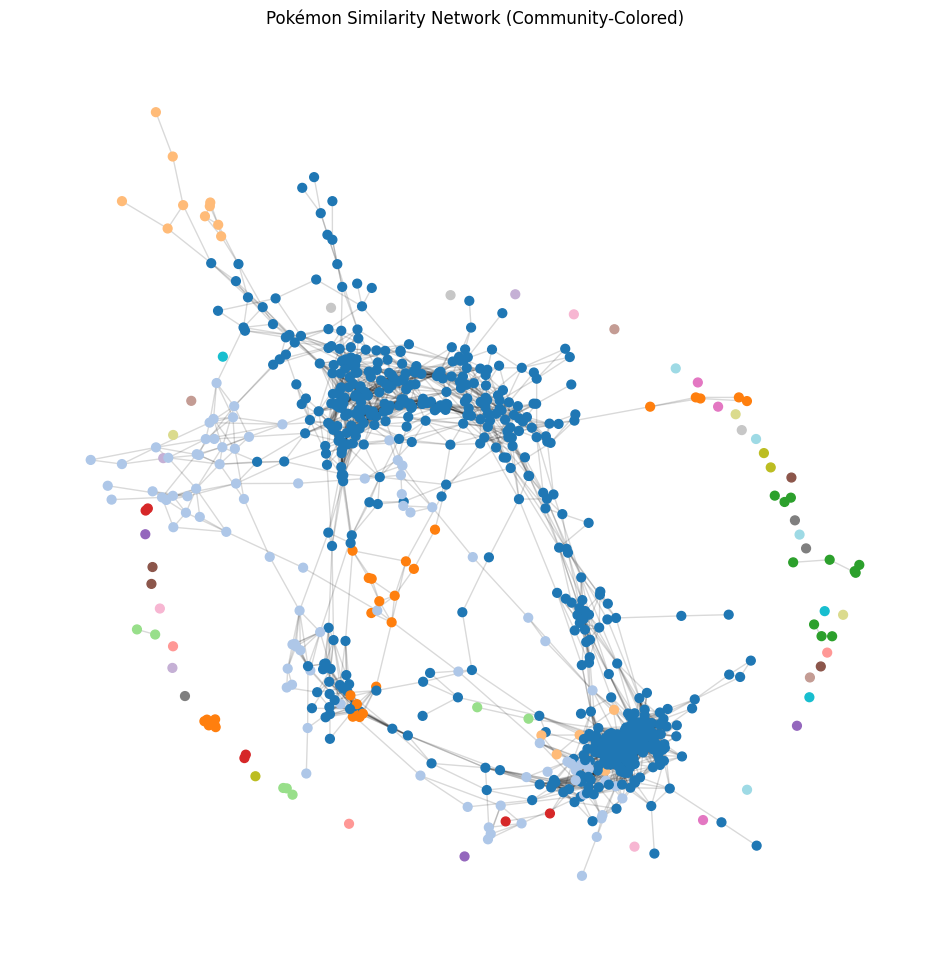

In [183]:

pos = nx.spring_layout(G, k=0.15, seed=42)
node_colors = df['Community']


plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=node_colors, cmap='tab20')
nx.draw_networkx_edges(G, pos, alpha=0.15)
plt.title("Pokémon Similarity Network (Community-Colored)")
plt.axis('off')
plt.show()

In [184]:
print(df.head())

                    Name Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  \
0              Bulbasaur  Grass  Poison    318  45      49       49       65   
1                Ivysaur  Grass  Poison    405  60      62       63       80   
2               Venusaur  Grass  Poison    525  80      82       83      100   
3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123      122   
4             Charmander   Fire    None    309  39      52       43       60   

   Sp. Def  Speed  Generation  Legendary Label       PC1       PC2  Cluster  \
0       65     45           1          0     0 -1.556375  0.021482        0   
1       80     60           1          0     1 -0.362867  0.050269        1   
2      100     80           1          0     2  1.280152  0.062720        1   
3      120     80           1          0     3  2.620916 -0.704263        2   
4       50     65           1          0     4 -1.758284  0.706179        0   

   DegreeCent  BetweennessCent  ClosenessCen